***
## Code build on Python 3.7.11 (64 bit) Windows in VS Code 1.60.2
***

In [1]:
# imports
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.pipeline import Pipeline

import warnings
#warnings.filterwarnings('ignore')

import sys
import warnings
import os
#warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [2]:
# load data
data = load_digits(as_frame=False) # load data and create a dataframe in .frame
print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
# data as dataframe
# data_df = data.frame
data_df = pd.DataFrame(data.data, columns=data.feature_names)
target_series = pd.Series(data.target)
data_df = pd.concat([data_df, pd.DataFrame({'target':data.target})], axis=1)
print('data shape', data_df.shape)
data_df.head()

data shape (1797, 65)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


***
## Every row (excluding target) represents a digit whereas target specifies what that digit is 
## There are 1797 digits in dataset each with already specified target
***

***
## Visualize Digits dataset
***

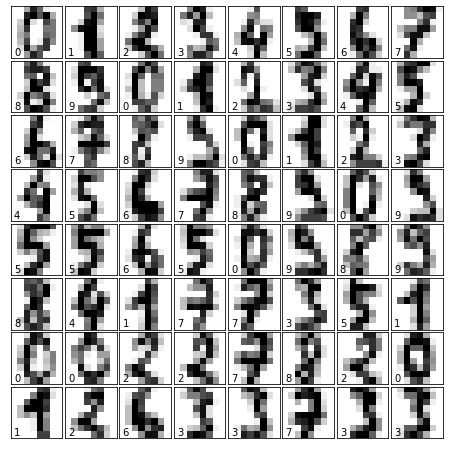

In [4]:
# show Images from data
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(data.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(data.target[i]))

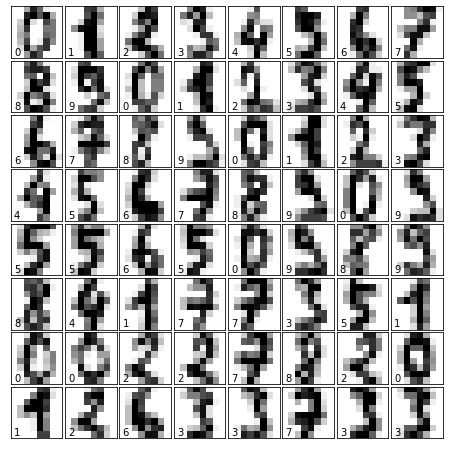

In [5]:
def plot_digits(data, expected_target=None, predicted_target=None, observations_to_plot=64, figsize=6):
    '''
    show inages from data by readng pixel columns
    inputs:
    data -> Input data
    expected_target -> labelled target
    predicted_target -> predicted values
    observations_to_plot -> count of observations to plot from expected/predicted
    '''
    fig = plt.figure(figsize=(figsize, figsize))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot equal dimentions (a x a)..so for 100 observations_to_plot, we plot 10 x 10
    # for 101 ,we plot 11 x 11
    decimal, integer = math.modf(np.sqrt(observations_to_plot))
    entries = integer if decimal == 0 else (integer+1)
        
    for i in range(observations_to_plot):
        ax = fig.add_subplot(entries, entries, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        if (expected_target is not None) and (predicted_target is None):
            ax.text(0, 7, str(expected_target[i]))
        elif (expected_target is not None) and (predicted_target is not None):
            if predicted_target[i] == expected_target[i]:
                ax.text(0, 7, str(predicted_target[i]), color='green')
            else:
                ax.text(0, 7, str(predicted_target[i]), color='red')

plot_digits(data.data, data.target)

***
## Reduce dimention to just 2 Principle components
## With only 2 dimentions, digits are even more washed out ->
***

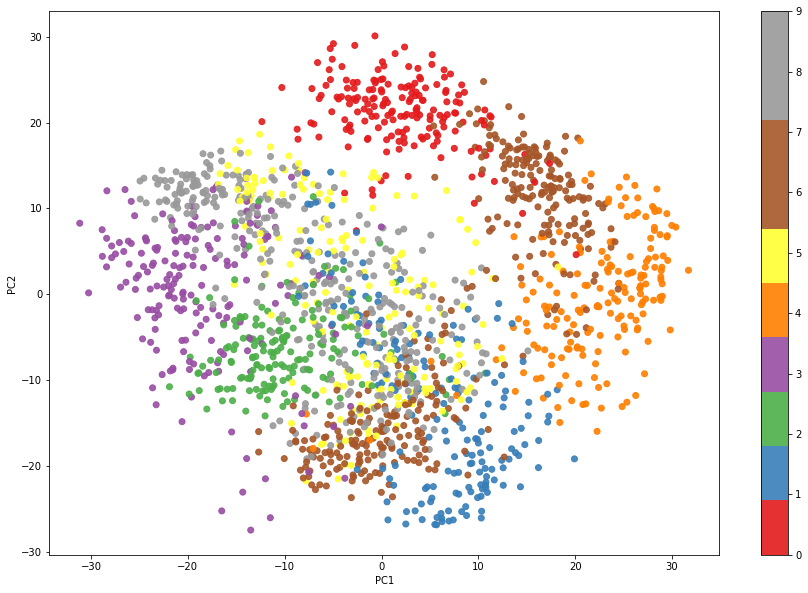

In [6]:
pca = PCA(n_components=2)
proj = pca.fit_transform(data.data)
# plot thesse 2 PC's
fig ,ax = plt.subplots(1,1, figsize=(15,10))
plt.scatter(proj[:, 0], proj[:,1], c=data.target, edgecolor=None, alpha=0.9, cmap = plt.get_cmap('Set1', 10))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

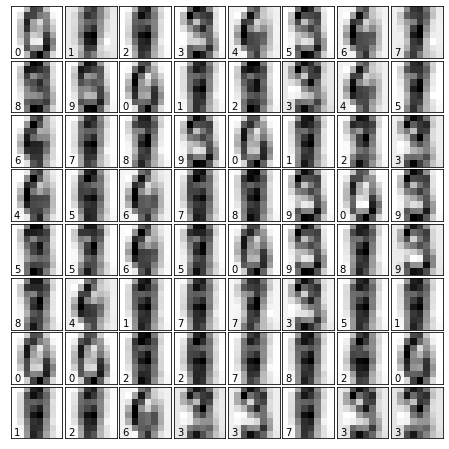

In [7]:
pca_transformed_dim_2 = pca.inverse_transform(proj)
plot_digits(pca_transformed_dim_2, data.target)

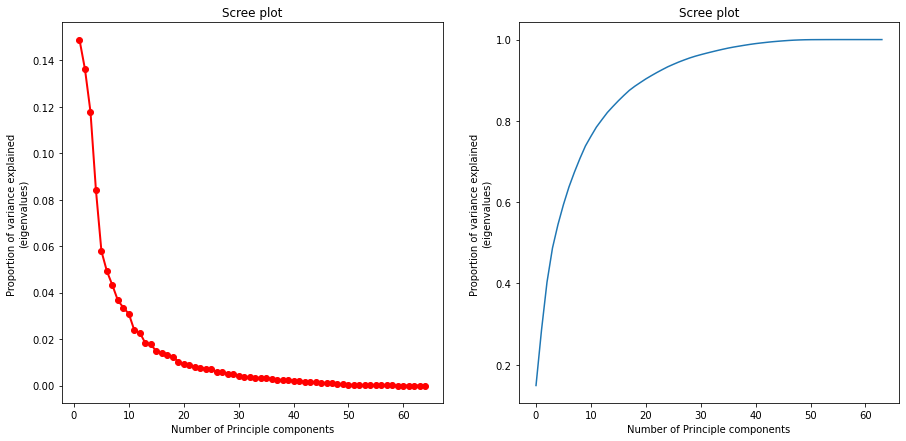

In [8]:
#scree plot to find those optimum components required to plot digits within reasonable acceptance range
sklearn_pca = PCA(n_components=data.data.shape[1]) # for 64 features there can be 64 PC's ...take all 64 PC's
sklearn_pca.fit(data.data)
plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1,2,1)
PC_values = np.arange(sklearn_pca.n_components_) + 1
plt.plot(PC_values, sklearn_pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.subplot(1,2,2)
plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.show()

***
## From above plots its clear max variation is explained by 10 PC's
## Check with both 10 ,15 and  20 PC's
***

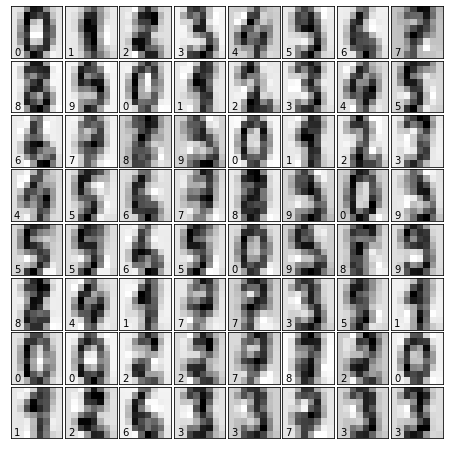

In [9]:
sklearn_pca = PCA(n_components=10)
proj = sklearn_pca.fit_transform(data.data)
pca_transformed_dim_10 = sklearn_pca.inverse_transform(proj)
plot_digits(pca_transformed_dim_10, data.target)

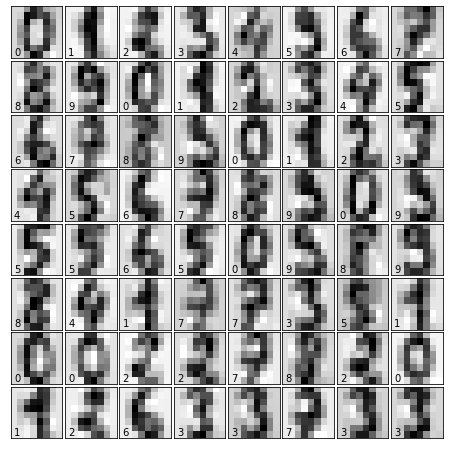

In [10]:
sklearn_pca = PCA(n_components=15)
proj = sklearn_pca.fit_transform(data.data)
pca_transformed_dim_10 = sklearn_pca.inverse_transform(proj)
plot_digits(pca_transformed_dim_10, data.target)

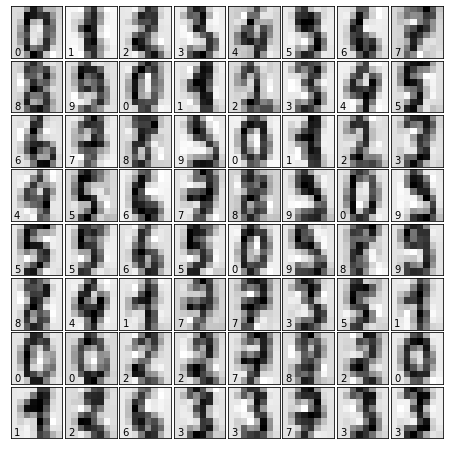

In [11]:
sklearn_pca = PCA(n_components=20)
proj = sklearn_pca.fit_transform(data.data)
pca_transformed_dim_10 = sklearn_pca.inverse_transform(proj)
plot_digits(pca_transformed_dim_10, data.target)

***
## Lets do regression to see how much of PC's reduction costs us (10 PC's)
***

In [12]:
# feature
x = data_df.iloc[:,0:-1]
print('x.shape', x.shape)
x.head()

x.shape (1797, 64)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [13]:
# target
y = data_df.iloc[:, -1]
print('y.shape:', y.shape)
y.head()

y.shape: (1797,)


0    0
1    1
2    2
3    3
4    4
Name: target, dtype: int32

In [14]:
#split train test
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=10)
print(x_train.shape, x_test.shape)

(1437, 64) (360, 64)


***
## Regression without PCA
***

In [15]:
# run logistic regression without PCA
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)
print(np.round(accuracy_score(y_predict, y_test) *100,2), '%')

95.83 %


***
## PCA Treatment
## Lets reduce the dimention from 64 (there are 64 features) to just 2 dimentions (accuracy comes around to just ~60%)
***

In [16]:
# PCA treatment
sklearn_pca = PCA(n_components=2)
sklearn_pca.fit(x_train)
x_train_transformed = sklearn_pca.transform(x_train)
x_test_transformed = sklearn_pca.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 2) (1437, 64)
(360, 2) (360, 64)


In [17]:
print('eigen values: ', sklearn_pca.explained_variance_)



eigen values:  [176.26809188 163.08355076]


Total variance explained :  28.22 %
Total no of PC's:  2


,PC1,PC2
0,14.66,13.56


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

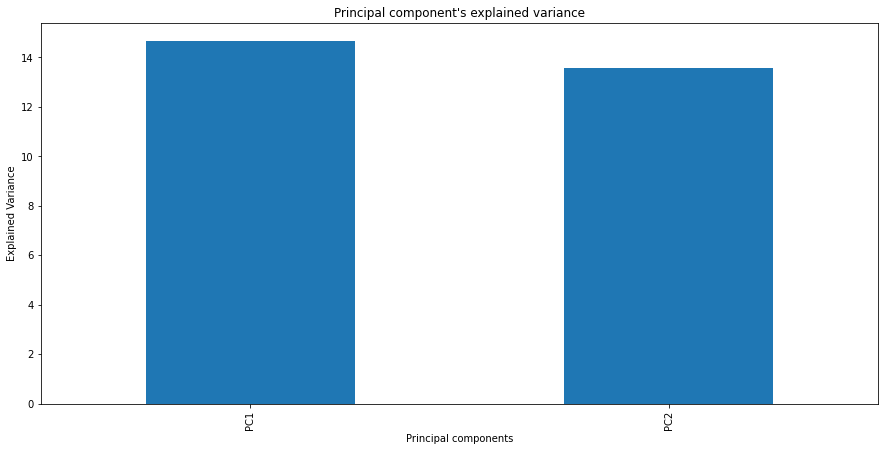

In [18]:
# results of PCA treatment
pc_nos= np.arange(0, len(sklearn_pca.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_pca.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of PC's: ", sklearn_pca.n_components_)
df_PC = pd.DataFrame(data={'PC{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_pca.explained_variance_ratio_)}, index=[0])
display(df_PC)
df_PC.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

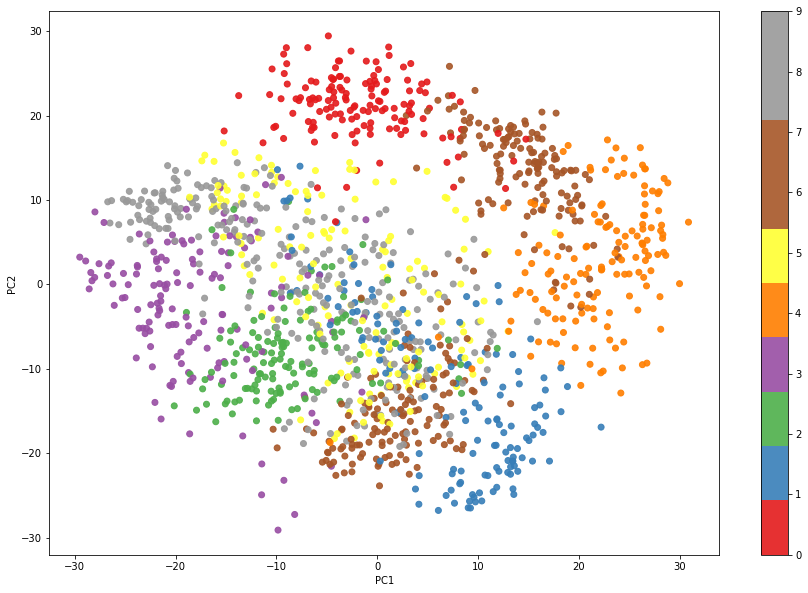

In [19]:
# plot thesse 2 PC's
fig ,ax = plt.subplots(1,1, figsize=(15,10))
plt.scatter(x_train_transformed[:, 0], x_train_transformed[:,1], c=y_train, edgecolor=None, alpha=0.9, cmap = plt.get_cmap('Set1', 10))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

Accuracy:  59.72 %


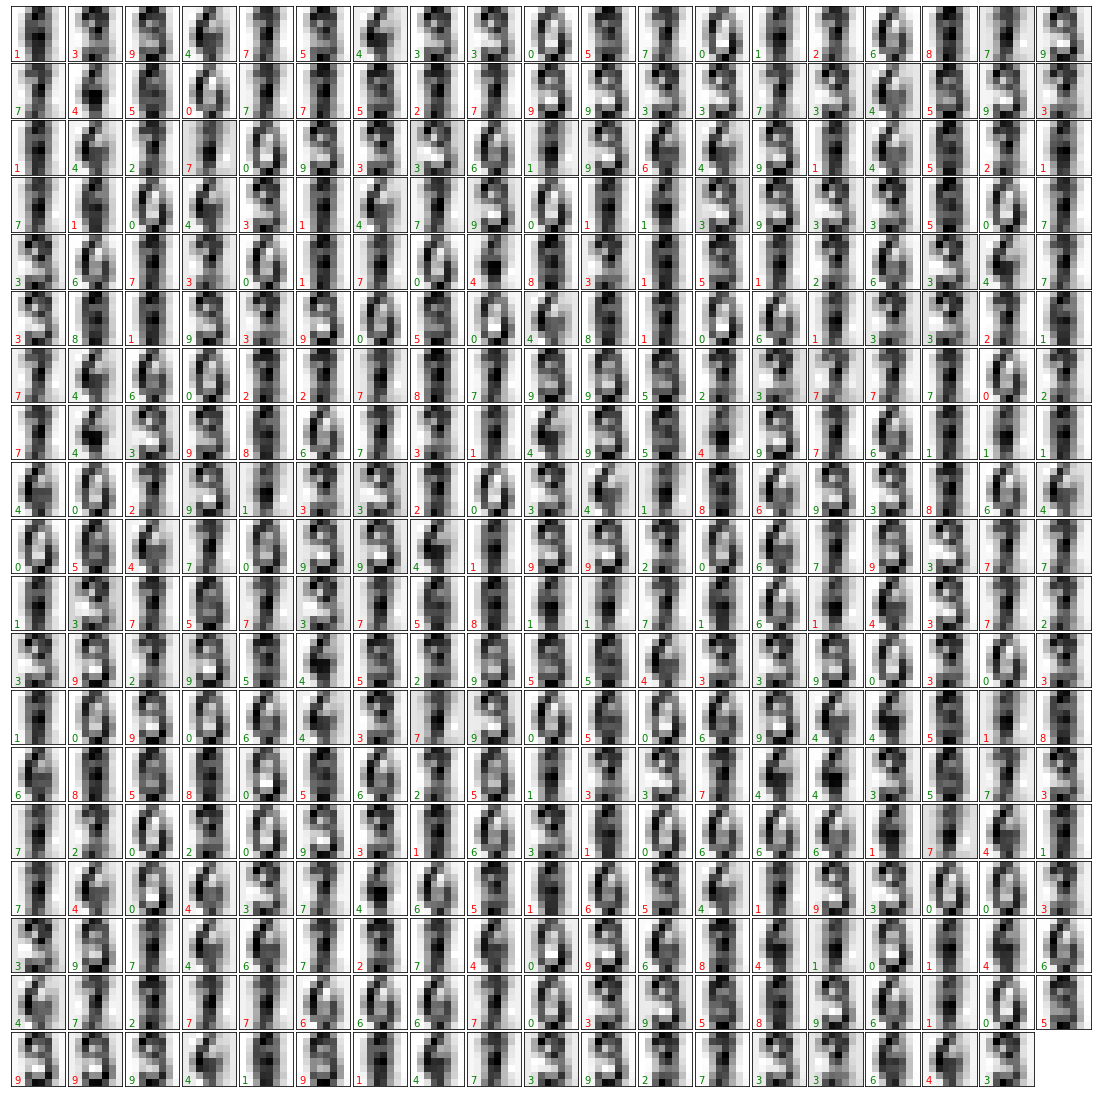

In [20]:
# run logistic regression with PCA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
x_test_detransformed = sklearn_pca.inverse_transform(x_test_transformed)
plot_digits(x_test_detransformed, y_test.to_list(), y_predict, x_test_detransformed.shape[0], 15)


***
## Regression with PCA (there are 64 features so 64 PC)
## n_components = 0.95 tells to select PC's such that total variance explained by them be greated than 95%
***

In [21]:
# PCA treatment
sklearn_pca = PCA(n_components=0.95)
sklearn_pca.fit(x_train)
x_train_transformed = sklearn_pca.transform(x_train)
x_test_transformed = sklearn_pca.transform(x_test)
print(x_train_transformed.shape, x_train.shape) # Dimentions reduced to 28 for 95% variance
print(x_test_transformed.shape, x_test.shape) # Dimentions reduced to 28 for 95% variance

(1437, 28) (1437, 64)
(360, 28) (360, 64)


Total variance explained :  95.03 %
Total no of PC's:  28


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0,14.66,13.56,11.9,8.58,5.88,4.89,4.35,3.69,3.33,3.06,...,1.0,0.91,0.88,0.79,0.76,0.71,0.68,0.61,0.57,0.51


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

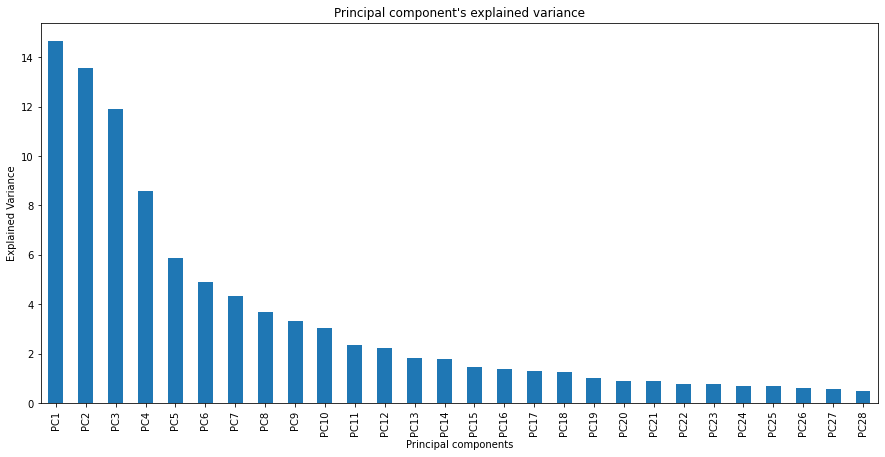

In [22]:
# results of PCA treatment
pc_nos= np.arange(0, len(sklearn_pca.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_pca.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of PC's: ", sklearn_pca.n_components_)
df_PC = pd.DataFrame(data={'PC{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_pca.explained_variance_ratio_)}, index=[0])
display(df_PC)
df_PC.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

95.0 %


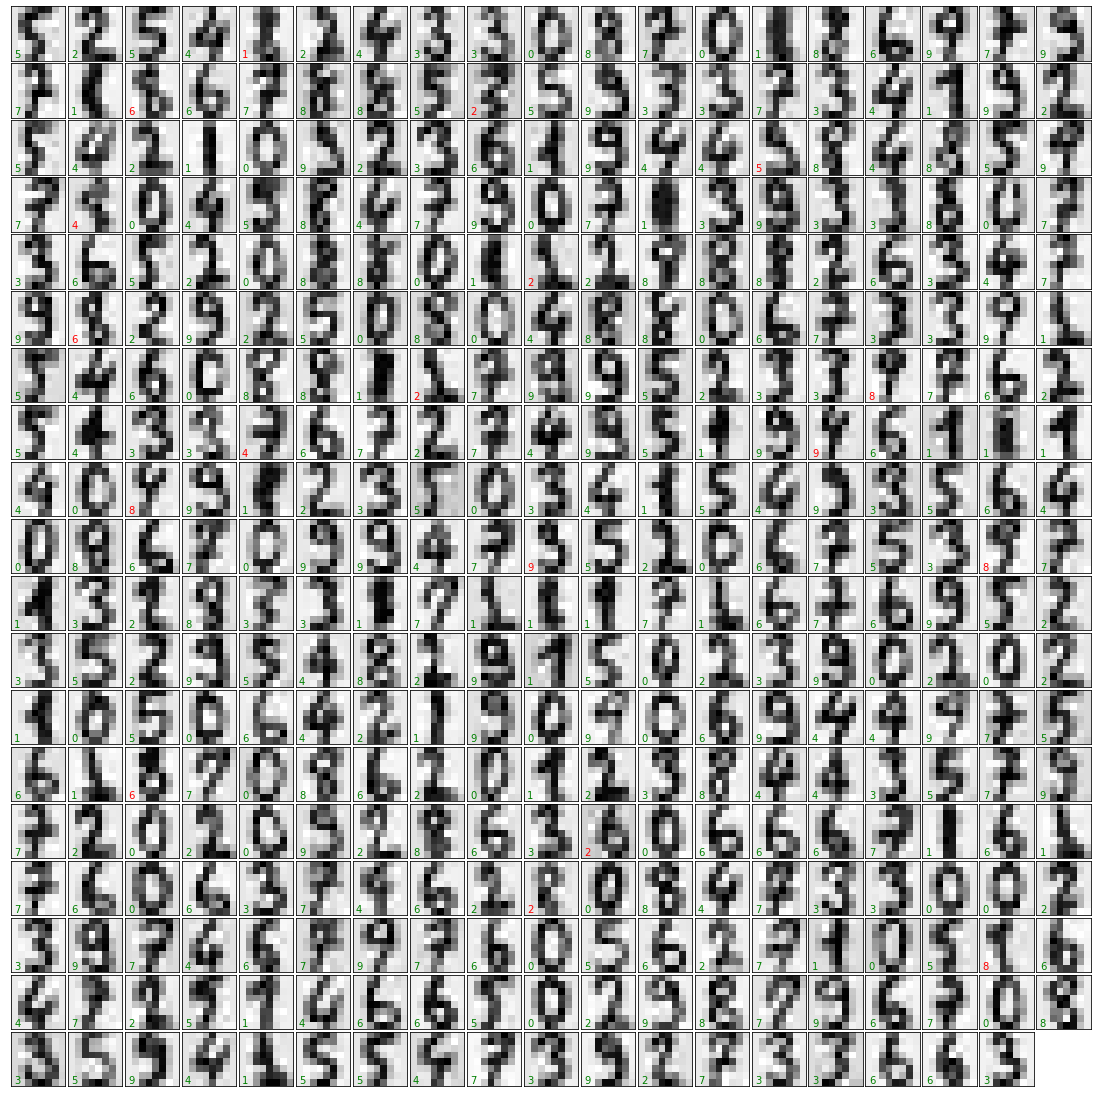

In [23]:
# run ligistic regression with PCA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print(np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
x_test_detransformed = sklearn_pca.inverse_transform(x_test_transformed)
plot_digits(x_test_detransformed, y_test.to_list(), y_predict, x_test_detransformed.shape[0], 15)

***
## Above score is almost same without PCA treatment 
## Find the optimum components that explain max variance using scree plot
***

In [24]:
# PCA treatment with all features
sklearn_pca = PCA(n_components=x_train.shape[1])
sklearn_pca.fit(x_train)
x_train_transformed = sklearn_pca.transform(x_train)
x_test_transformed = sklearn_pca.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 64) (1437, 64)
(360, 64) (360, 64)


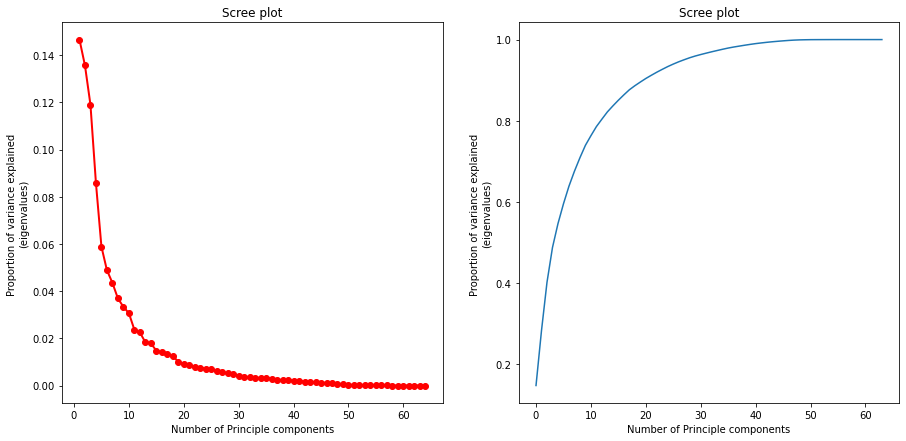

In [25]:
#scree plot
plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1,2,1)
PC_values = np.arange(sklearn_pca.n_components_) + 1
plt.plot(PC_values, sklearn_pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.subplot(1,2,2)
plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
plt.title('Scree plot')
plt.xlabel('Number of Principle components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.show()

***
## Max variance can be seen till 10 PC's (apprx 75 %), after that the variance is not that much
## Choosing n_components=10, PCA and regression
***

In [26]:
# PCA treatment
sklearn_pca = PCA(n_components=10, whiten=True, iterated_power=6)
sklearn_pca.fit(x_train)
x_train_transformed = sklearn_pca.transform(x_train)
x_test_transformed = sklearn_pca.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 10) (1437, 64)
(360, 10) (360, 64)


Total variance explained :  73.92 %
Total no of PC's:  10


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,14.66,13.56,11.9,8.58,5.88,4.89,4.35,3.69,3.33,3.06


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

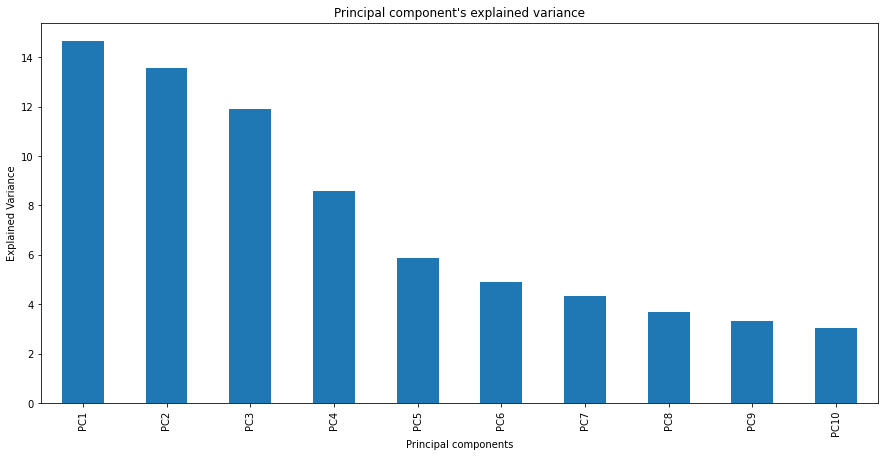

In [27]:
# results of PCA treatment
pc_nos= np.arange(0, len(sklearn_pca.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_pca.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of PC's: ", sklearn_pca.n_components_)
df_PC = pd.DataFrame(data={'PC{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_pca.explained_variance_ratio_)}, index=[0])
display(df_PC)
df_PC.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

93.61 %


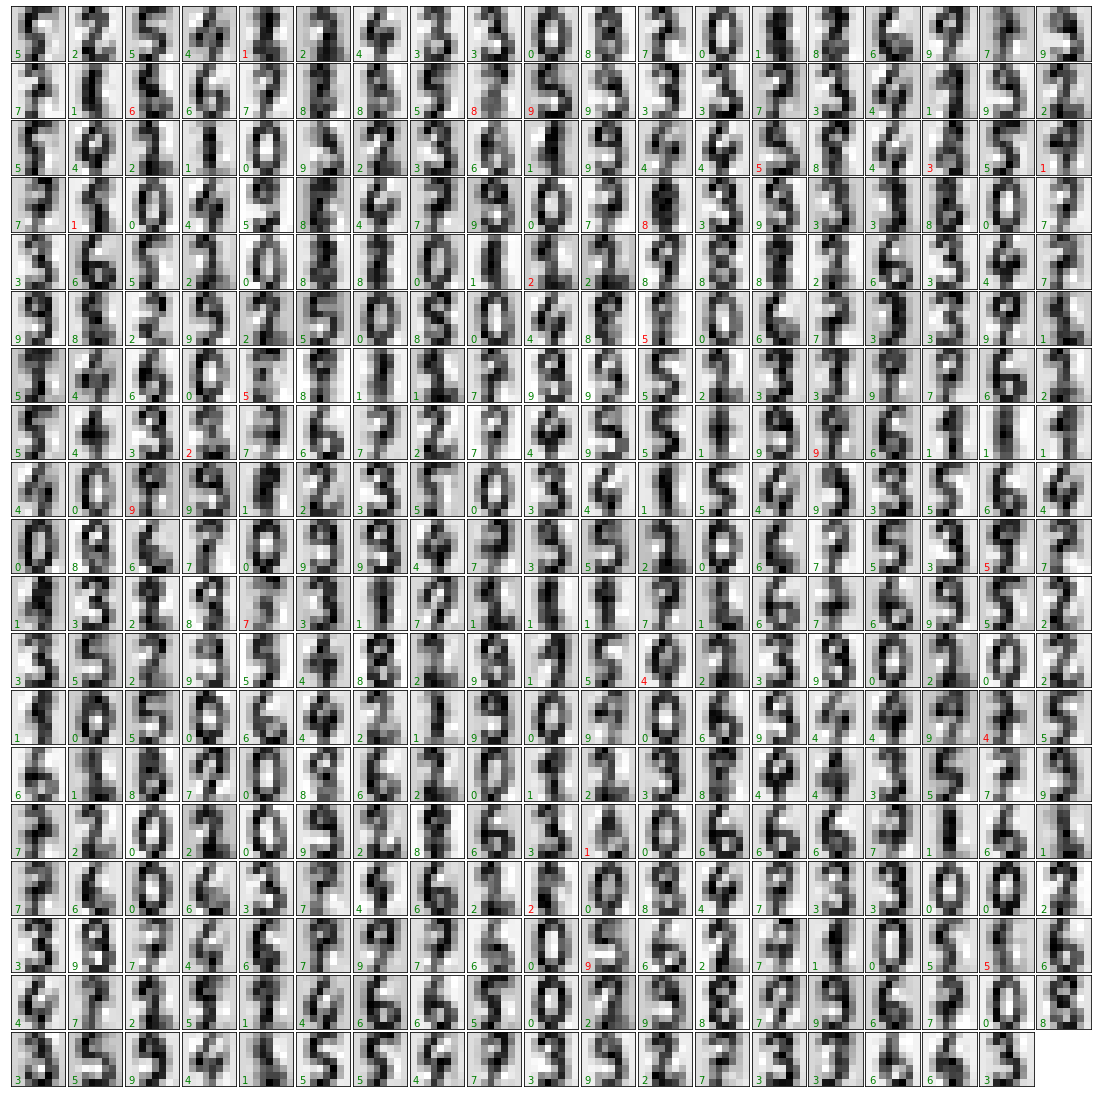

In [28]:
# run ligistic regression with PCA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print(np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
x_test_detransformed = sklearn_pca.inverse_transform(x_test_transformed)
plot_digits(x_test_detransformed, y_test.to_list(), y_predict, x_test_detransformed.shape[0], 15)

***
## While still keeping the accuracy 93.33 % (close to 95.33 without PCS treatment), dimentionality of data is reduced from 64 to 10
***

***
# LDA Analysis
***

In [29]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis(n_components=2)
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 2) (1437, 64)
(360, 2) (360, 64)


Total variance explained :  47.68 %
Total no of LDA's:  2


,LDA1,LDA2
0,29.12,18.56


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

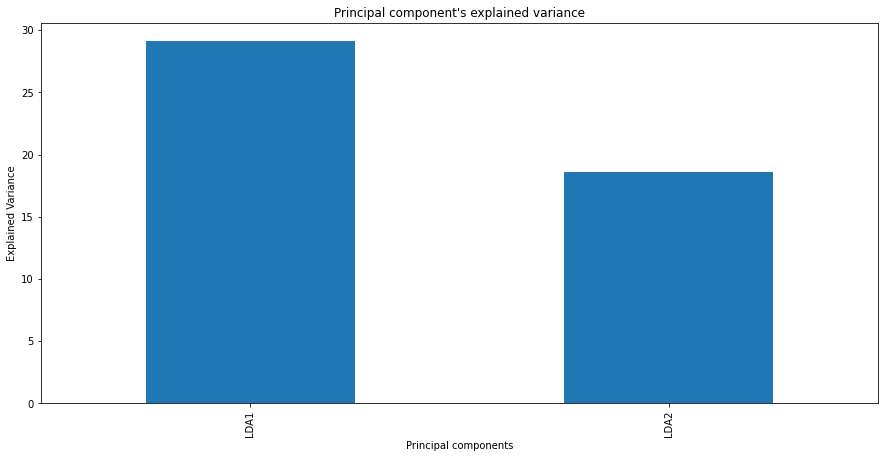

In [30]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

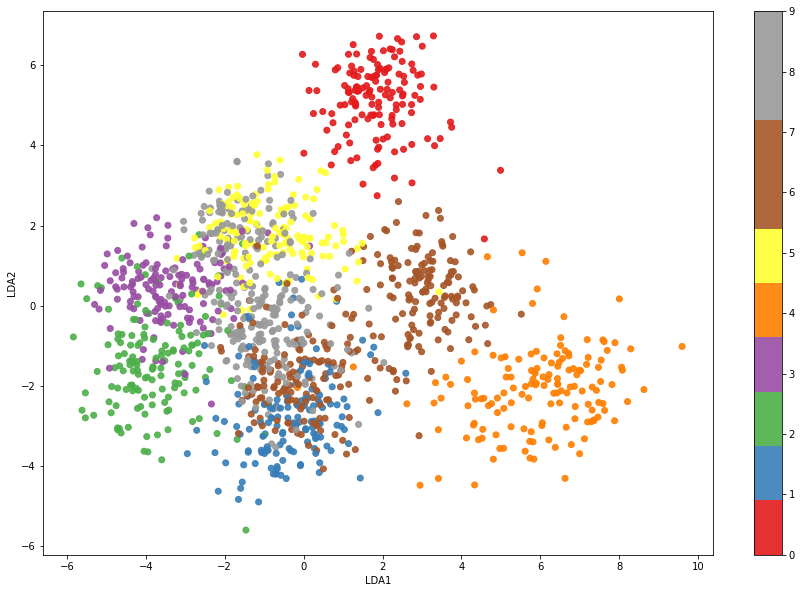

In [31]:
# plot thesse 2 LDA's
fig ,ax = plt.subplots(1,1, figsize=(15,10))
plt.scatter(x_train_transformed[:, 0], x_train_transformed[:,1], c=y_train, edgecolor=None, alpha=0.9, cmap = plt.get_cmap('Set1', 10))
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.colorbar()

Accuracy:  68.06 %


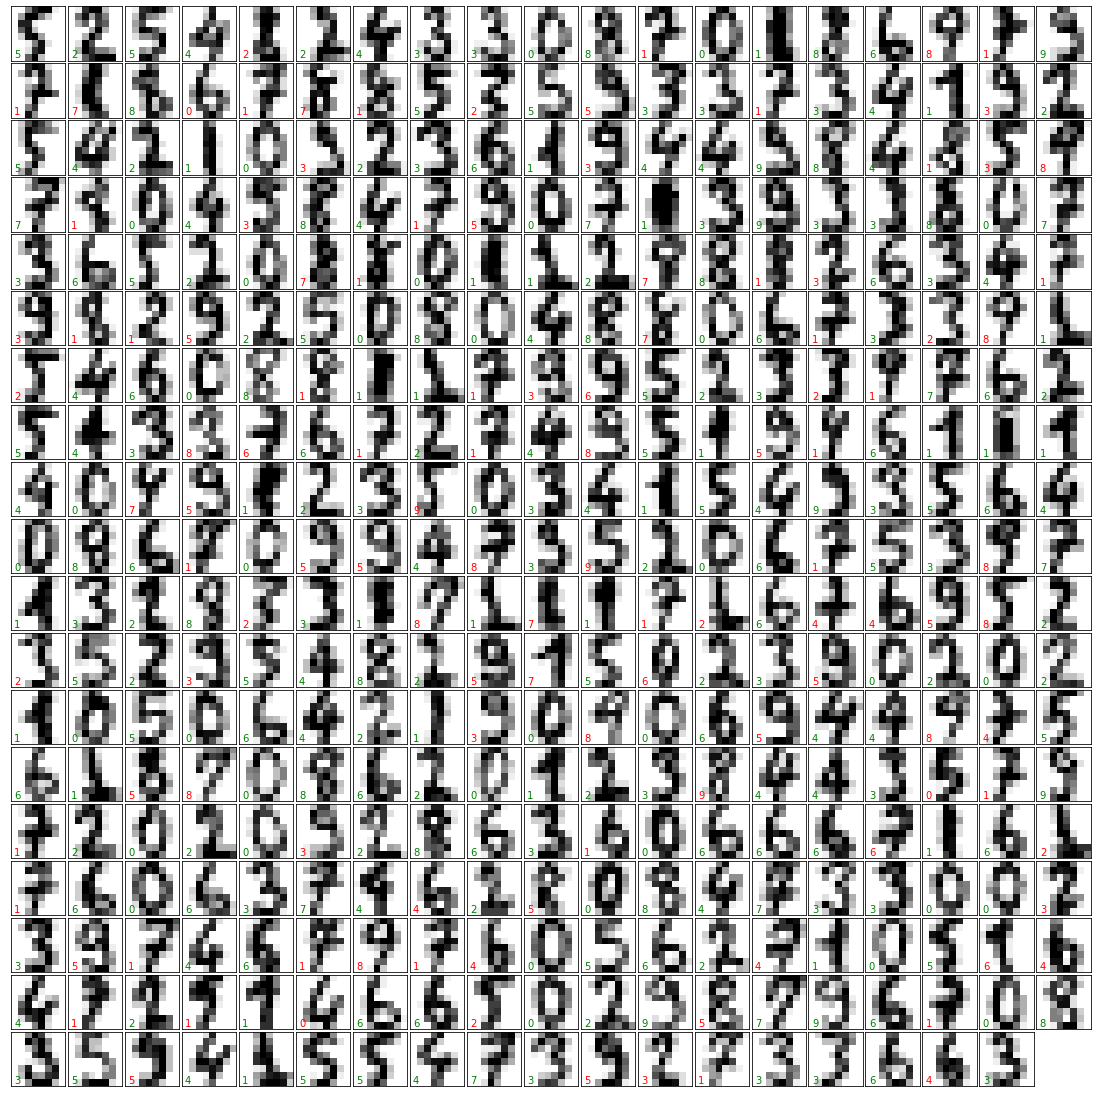

In [32]:
# run logistic regression with LDA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
plot_digits(x_test.values, y_test.to_list(), y_predict, x_test.shape[0], 15)

***
## Find the optimum components that explain max variance using scree plot
***

In [33]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis()
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 9) (1437, 64)
(360, 9) (360, 64)


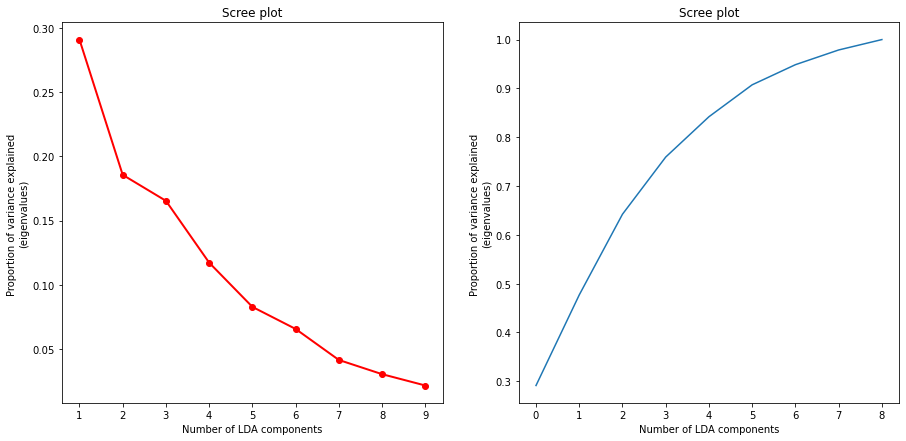

In [34]:
#scree plot
plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1,2,1)
PC_values = np.arange(len(sklearn_lda.explained_variance_ratio_)) + 1
plt.plot(PC_values, sklearn_lda.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree plot')
plt.xlabel('Number of LDA components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.subplot(1,2,2)
plt.plot(np.cumsum(sklearn_lda.explained_variance_ratio_))
plt.title('Scree plot')
plt.xlabel('Number of LDA components')
plt.ylabel('Proportion of variance explained \n(eigenvalues)')

plt.show()

Total variance explained :  100.0 %
Total no of LDA's:  9


,LDA1,LDA2,LDA3,LDA4,LDA5,LDA6,LDA7,LDA8,LDA9
0,29.12,18.56,16.54,11.71,8.26,6.54,4.12,3.01,2.13


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

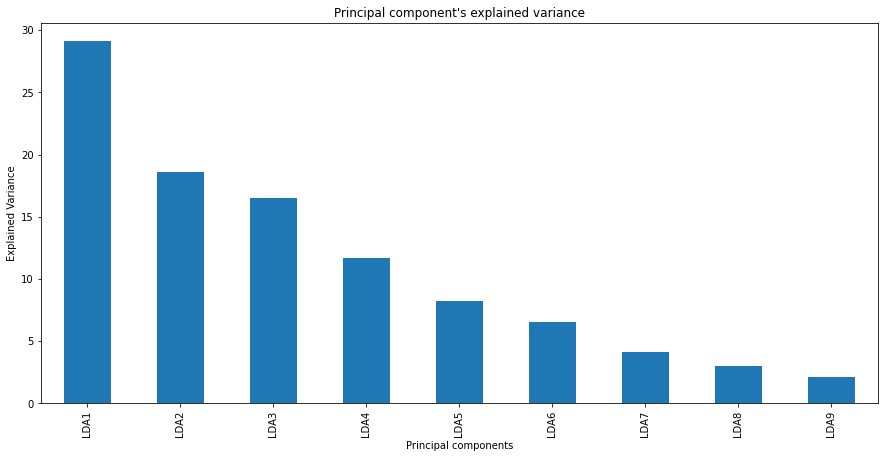

In [35]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

***
## The first 7 LDA's have most varaiance
## test with 3,4,5,6,7
***

In [36]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis(n_components=3)
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 3) (1437, 64)
(360, 3) (360, 64)


Total variance explained :  64.21 %
Total no of LDA's:  3


,LDA1,LDA2,LDA3
0,29.12,18.56,16.54


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

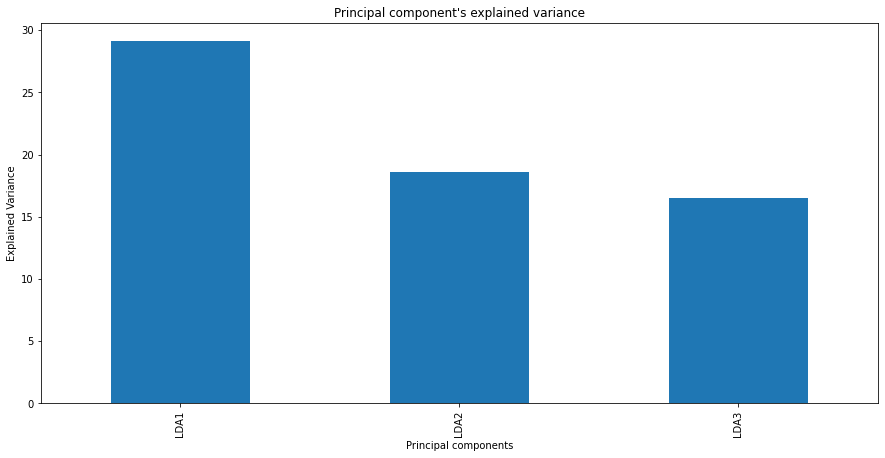

In [37]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

Accuracy:  81.11 %


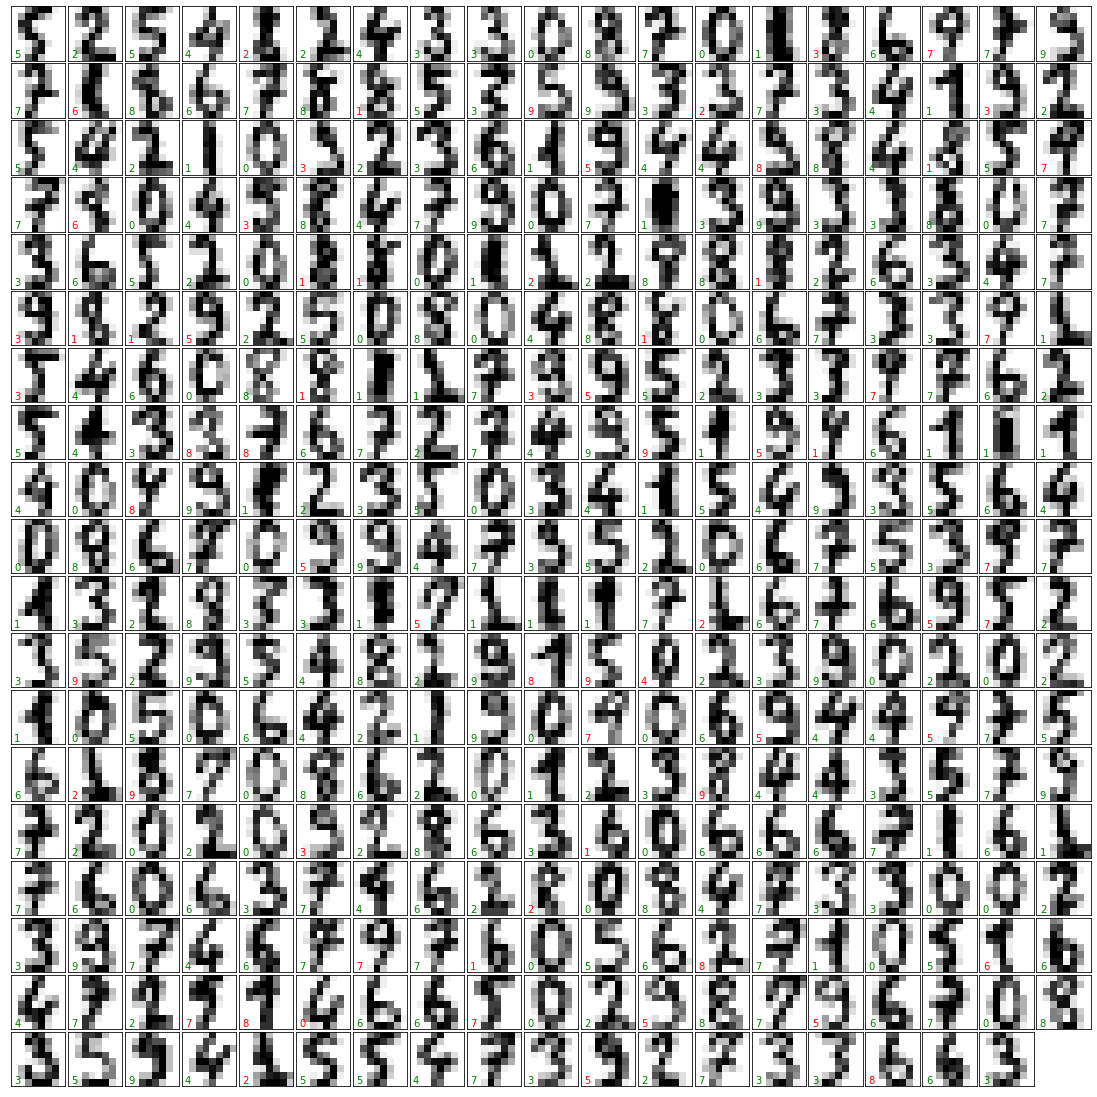

In [38]:
# run logistic regression with LDA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
plot_digits(x_test.values, y_test.to_list(), y_predict, x_test.shape[0], 15)

In [39]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis(n_components=4)
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 4) (1437, 64)
(360, 4) (360, 64)


Total variance explained :  75.93 %
Total no of LDA's:  4


,LDA1,LDA2,LDA3,LDA4
0,29.12,18.56,16.54,11.71


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

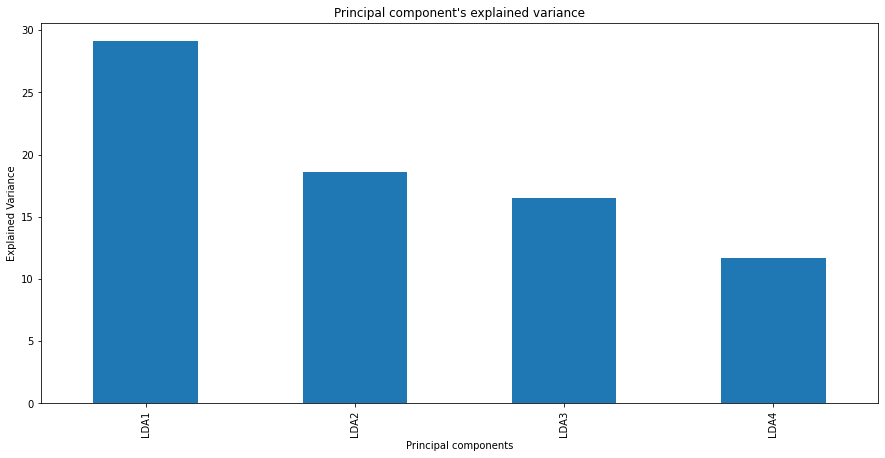

In [40]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

Accuracy:  87.5 %


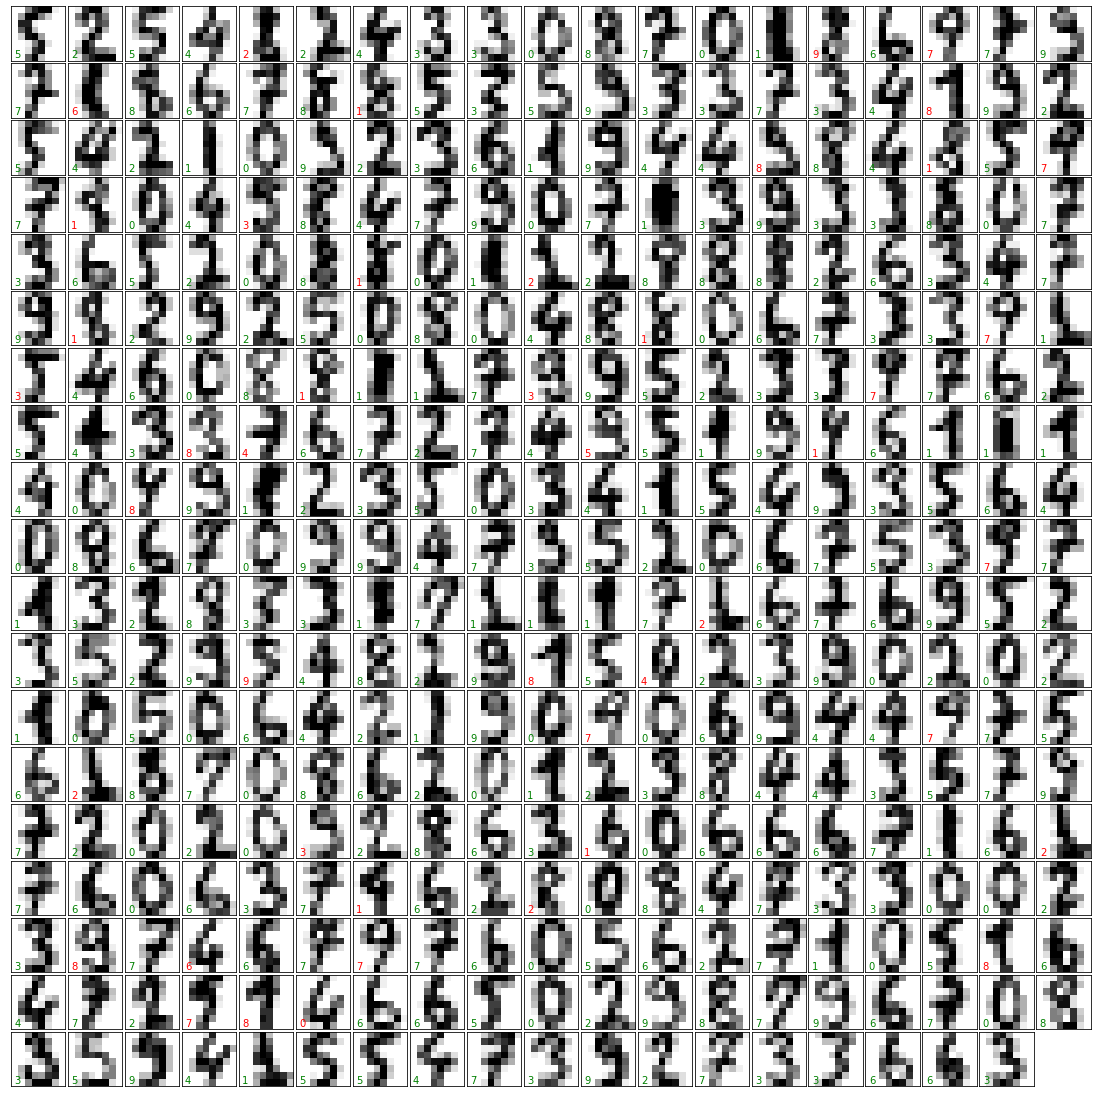

In [41]:
# run logistic regression with LDA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
plot_digits(x_test.values, y_test.to_list(), y_predict, x_test.shape[0], 15)

In [42]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis(n_components=5)
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 5) (1437, 64)
(360, 5) (360, 64)


Total variance explained :  84.19 %
Total no of LDA's:  5


,LDA1,LDA2,LDA3,LDA4,LDA5
0,29.12,18.56,16.54,11.71,8.26


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

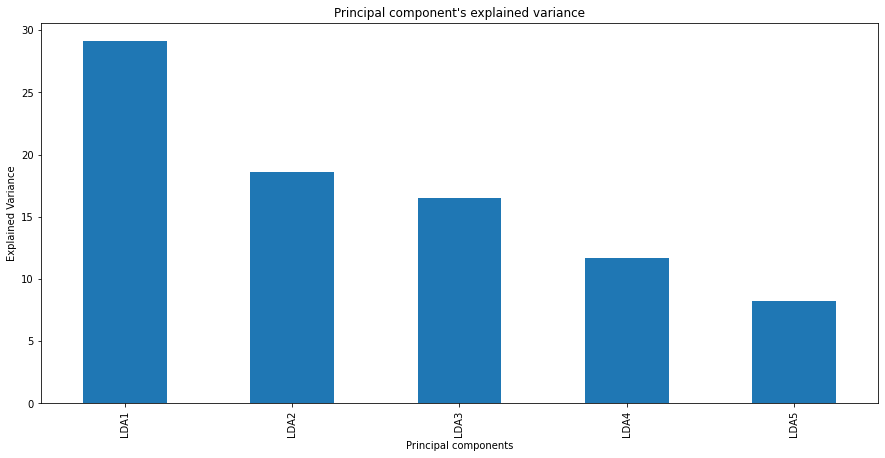

In [43]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

Accuracy:  90.0 %


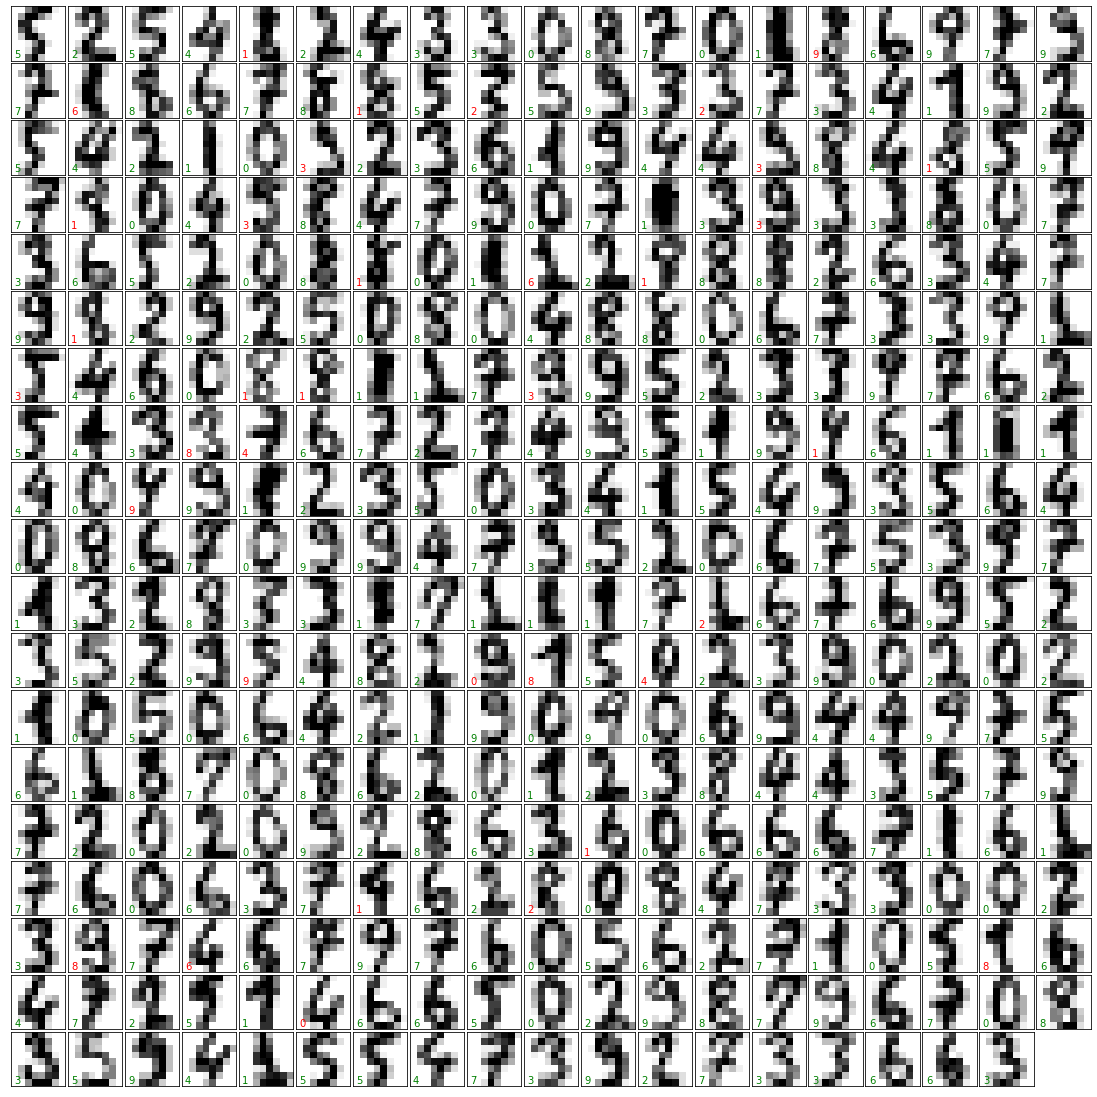

In [44]:
# run logistic regression with LDA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
plot_digits(x_test.values, y_test.to_list(), y_predict, x_test.shape[0], 15)

In [45]:
# LDA treatment
sklearn_lda = LinearDiscriminantAnalysis(n_components=7)
sklearn_lda.fit(x_train, y_train)
x_train_transformed = sklearn_lda.transform(x_train)
x_test_transformed = sklearn_lda.transform(x_test)
print(x_train_transformed.shape, x_train.shape)
print(x_test_transformed.shape, x_test.shape)

(1437, 7) (1437, 64)
(360, 7) (360, 64)


Total variance explained :  94.85 %
Total no of LDA's:  7


,LDA1,LDA2,LDA3,LDA4,LDA5,LDA6,LDA7
0,29.12,18.56,16.54,11.71,8.26,6.54,4.12


<AxesSubplot:title={'center':"Principal component's explained variance"}, xlabel='Principal components', ylabel='Explained Variance'>

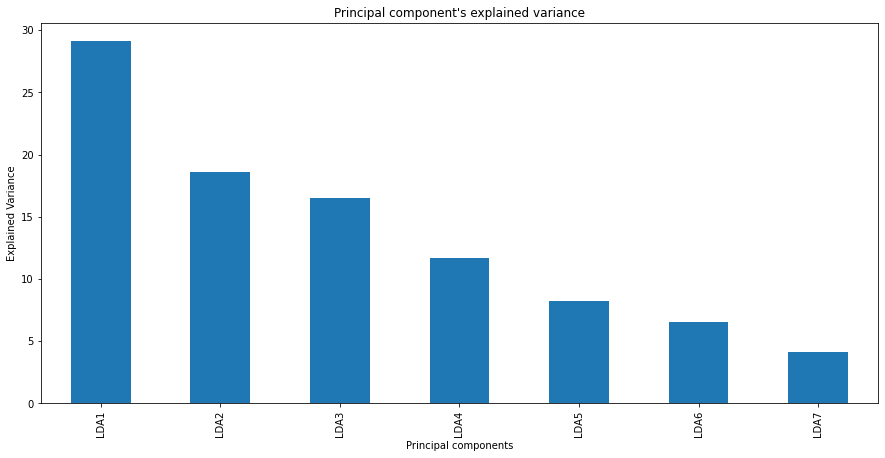

In [46]:
# results of LDA treatment
pc_nos= np.arange(0, len(sklearn_lda.explained_variance_ratio_))+1
print('Total variance explained : ', np.round(sklearn_lda.explained_variance_ratio_.sum()*100, 2), '%')
print("Total no of LDA's: ", len(sklearn_lda.explained_variance_ratio_))
df_LDA = pd.DataFrame(data={'LDA{}'.format(i): np.round(val*100, 2) for i,val in zip(pc_nos, sklearn_lda.explained_variance_ratio_)}, index=[0])
display(df_LDA)
df_LDA.T.plot(kind='bar', title="Principal component's explained variance", ylabel='Explained Variance', xlabel='Principal components', legend= False)

Accuracy:  91.11 %


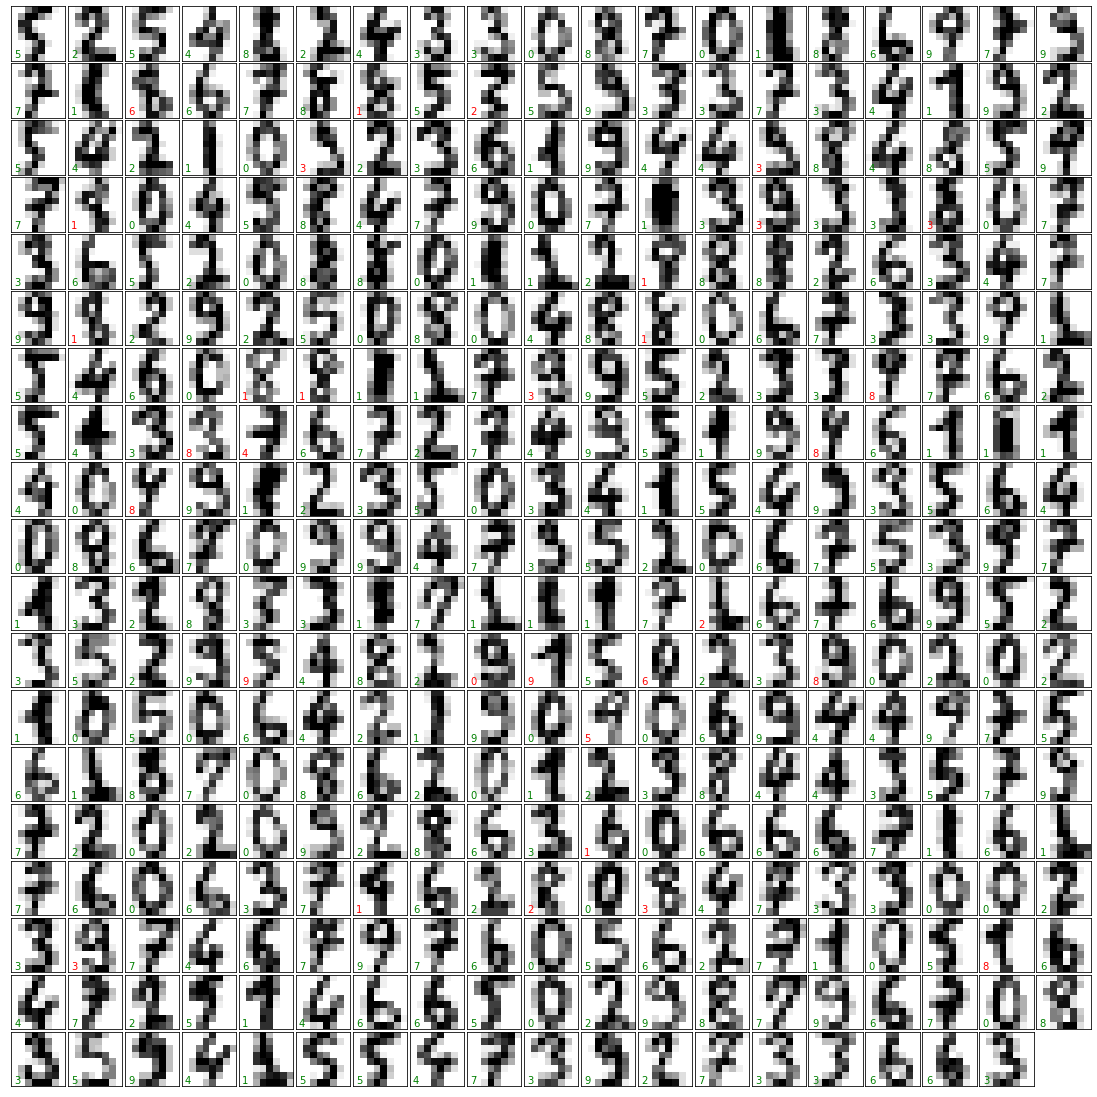

In [47]:
# run logistic regression with LDA treatment
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(x_train_transformed, y_train)
y_predict = lr.predict(x_test_transformed)
print('Accuracy: ',np.round(accuracy_score(y_predict, y_test) *100,2),'%')

# plot the test digits comparing the predictions (red color text in bottom left corner indicates we were wrong in predicting those entries)
plot_digits(x_test.values, y_test.to_list(), y_predict, x_test.shape[0], 15)

***
## n_components = 7 has accuracy of 91.11 % whereas n_components = 5 has accuracy of 90.0 %
## Accuracy has slightly increased from 5 LDA's to 7 LDA's
## Choosing 5 LDA's as optimum for now
***

***
# Step-by-step analysis is done, use 1-shot methods to find best of Classifiers, PCA ad LDA
***

***
## Classifiers with hyperparameter tuning
***

In [48]:
# choosing best classifier

clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

df_search = pd.DataFrame()
for classifier in clfs:
    pipeline = Pipeline([('normalizer', StandardScaler()), ('clf:', classifier)])
    scores = cross_validate(pipeline, X=x.values, y=y.values, cv=cv)
    df_search = df_search.append({key: value.mean() for key,value in scores.items()}, ignore_index=True)  

df_search.index = clfs

In [49]:
df_search.sort_values(by = 'test_score', ascending=False, inplace=True)
display(df_search)

,fit_time,score_time,test_score
SVC(),0.072709,0.015458,0.982926
KNeighborsClassifier(),0.002459,0.009507,0.978483
RandomForestClassifier(),0.242485,0.009740,0.977552
LogisticRegression(),0.104919,0.000366,0.971624
GradientBoostingClassifier(),5.390430,0.003518,0.966983
DecisionTreeClassifier(),0.016889,0.000498,0.852541


Best performer:
 fit_time      0.072709
score_time    0.015458
test_score    0.982926
Name: SVC(), dtype: float64


***
## Choosing SVC classifier from top classifiers (test_score)
***

***
## Use SVC classifier, find best solver (for SVC) and best PCA components
***

In [50]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
SCORING = ['accuracy', 'precision', 'recall', 'f1' ]

pipe = Pipeline(steps=[('normalizer', StandardScaler()), ('pca', PCA()), ('svc', SVC())])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 10, 15, 30, 45, 50],
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'precomputed'],
}

search = GridSearchCV(pipe, param_grid, scoring=SCORING[0], cv=cv, refit='f1', return_train_score=True)
search.fit(x.values, y.values)

print("Best parameter (CV score={0:0.2f}%):".format(search.best_score_*100))
print(search.best_params_)

Best parameter (CV score=98.26%):
{'pca__n_components': 50, 'svc__kernel': 'rbf'}


,param_pca__n_components,param_svc__kernel,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,5,rbf,0.880906,0.020063,14.0,0.898885,0.004317
5,10,rbf,0.946390,0.017700,9.0,0.966425,0.002616
9,15,rbf,0.972364,0.013131,6.0,0.988376,0.001377
13,30,rbf,0.982007,0.011565,3.0,0.996084,0.000583
17,45,rbf,0.982378,0.011690,2.0,0.996311,0.000586
21,50,rbf,0.982565,0.011111,1.0,0.996888,0.000648


<AxesSubplot:xlabel='param_pca__n_components'>

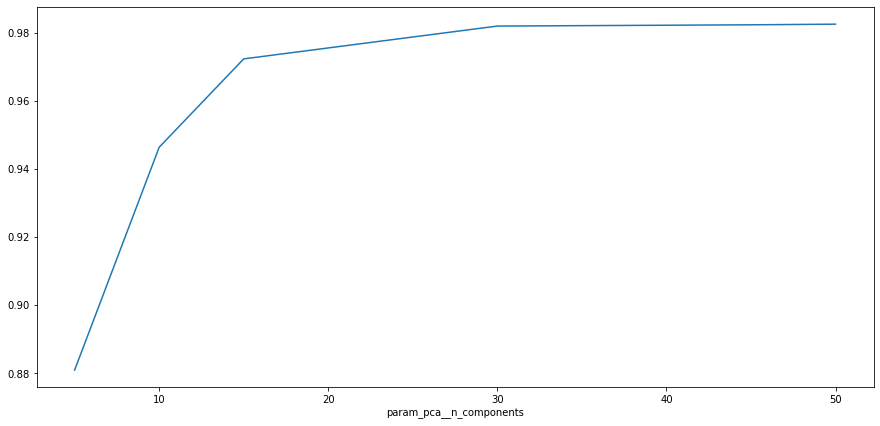

In [51]:
useful_cv_params = [x for x in list(search.cv_results_) if not (x.startswith('split') or x.startswith('params') or x.endswith('time'))]
df_results = pd.DataFrame()
for param in useful_cv_params:
    df_results[param] = search.cv_results_[param]

df_results = df_results[df_results['mean_test_score'].notna()]
#display(df_results)

df_temp = pd.DataFrame()
df_grouped = df_results.groupby(['param_pca__n_components'], as_index=False).max('mean_test_score')
for pca, acc_metric in zip(df_grouped.param_pca__n_components, df_grouped.mean_test_score):
    index = df_results.where((df_results['param_pca__n_components'] == pca) & (df_results['mean_test_score'] == acc_metric)).notna()
    df_temp = pd.concat([df_temp, df_results[index].dropna(axis=0)], axis=0)

display(df_temp) 

df_temp.set_index('param_pca__n_components', inplace=True)
df_temp['mean_test_score'].plot.line()


***
## Max variation is captured by first 10 PC's with accuracy of ~94 % (mean_test_score), thereafter variance does not change much. So with 94% accuracy using SVC(solver='rbf'), we get optimum results while reducing dimensions.
>> ## One can use train_test_split and check the results using PCA(n_components=10) and SVC(solver='rbf)
***

***
## Use SVC classifier, find best solver (for SVC) and best LDA components
***

In [52]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
SCORING = ['accuracy', 'precision', 'recall', 'f1' ]

pipe = Pipeline(steps=[('normalizer', StandardScaler()), ('lda', LinearDiscriminantAnalysis()), ('svc', SVC())])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'lda__n_components': [4,5,6,7,8,9],
    'lda__solver':  ['svd', 'lsqr', 'eigen'],
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'precomputed'],
}

search = GridSearchCV(pipe, param_grid, scoring=SCORING[0], cv=cv, refit='f1', return_train_score=True)
search.fit(x.values, y.values)

print("Best parameter (CV score={0:0.2f}%):".format(search.best_score_*100))
print(search.best_params_)

Best parameter (CV score=96.59%):
{'lda__n_components': 9, 'lda__solver': 'svd', 'svc__kernel': 'rbf'}


,param_lda__n_components,param_lda__solver,param_svc__kernel,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,4,svd,rbf,0.901881,0.021985,16.0,0.925328,0.002712
13,5,svd,rbf,0.930817,0.017718,13.0,0.948701,0.002377
25,6,svd,rbf,0.943065,0.017175,8.0,0.962654,0.001884
37,7,svd,rbf,0.948628,0.015951,7.0,0.967807,0.002205
49,8,svd,rbf,0.959011,0.014456,4.0,0.976030,0.001798
61,9,svd,rbf,0.965876,0.014182,1.0,0.984460,0.001634


<AxesSubplot:xlabel='param_lda__n_components'>

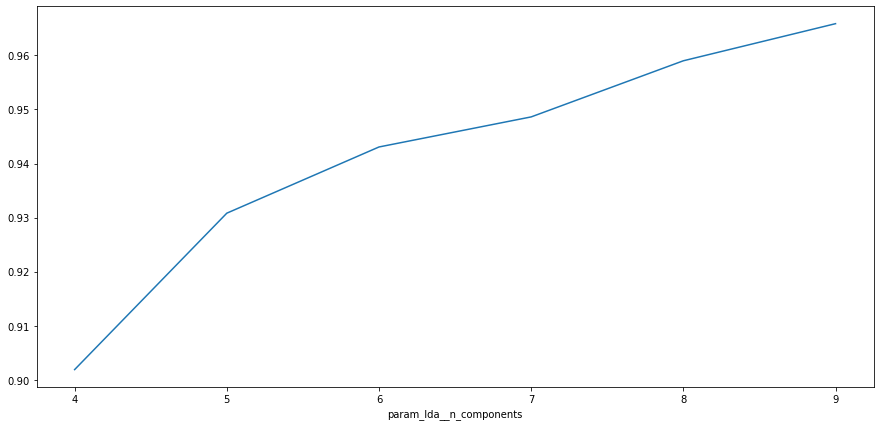

In [53]:
useful_cv_params = [x for x in list(search.cv_results_) if not (x.startswith('split') or x.startswith('params') or x.endswith('time'))]
df_results = pd.DataFrame()
for param in useful_cv_params:
    df_results[param] = search.cv_results_[param]

df_results = df_results[df_results['mean_test_score'].notna()]
#display(df_results)

df_temp = pd.DataFrame()
df_grouped = df_results.groupby(['param_lda__n_components'], as_index=False).max('mean_test_score')
for pca, acc_metric in zip(df_grouped.param_lda__n_components, df_grouped.mean_test_score):
    index = df_results.where((df_results['param_lda__n_components'] == pca) & (df_results['mean_test_score'] == acc_metric)).notna()
    df_temp = pd.concat([df_temp, df_results[index].dropna(axis=0)], axis=0)

display(df_temp) 

df_temp.set_index('param_lda__n_components', inplace=True)
df_temp['mean_test_score'].plot.line()


***
## 5 LDA's describe most of the variance(there is not much change after) so choosing LinearDiscriminantAnalysis(n_components=5) and SVC(solver='svd') should give optimum results
>> ## One can use train_test_split and check the results using LinearDiscriminantAnalysis(n_components=5) and SVC(solver='svd)
***